## 0.3 Bot or Human?: Binary Classification of Reddit Posts


### Contents:
- [Import Libraries](#Import-Libraries)
- [Read in data scrapped from subreddits](#Read-in-data-scrapped-from-subreddits)
- [Data Processing](#Data-Processing)
- [NLP Modelling](#NLP-Modelling)
- [Models Evaluation & Recommendation](#Models-Evaluation-&-Recommendation)

## Import Libraries

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## Read in data scrapped from subreddits

In [2]:
df_bot = pd.read_csv('../Data/bot.csv')

In [3]:
df_human = pd.read_csv('../Data/human.csv')

## Data Processing

A target column is created with binary values to classify posts under the bot subreddit as 1 and human subreddit, 0. 

In [4]:
#Categorises posts by indicting posts from Subredditsimulator as 1
df_bot['bot'] = 1

In [5]:
df_bot.head()

,post_title,name,bot
0,What is /r/SubredditSimulator?,t3_3g9ioz,1
1,"Only bots can post in /r/SubredditSimulator, c...",t3_3g9k92,1
2,How much porn is the worst feeling,t3_ch78vw,1
3,New Colin Kaepernick was removed from historic...,t3_chhf3p,1
4,Albert Wesker (Resident Evil) vs Flood infecte...,t3_cgsxyt,1


In [6]:
#Categorises posts by indicting posts from Showerthoughts as 0
df_human['bot'] = 0

In [7]:
df_human.head()

,post_title,name,bot
0,Your Essential Guide to Showerthoughts,t3_bg71oh,0
1,"The Quintessential Showerthought, Issue #1 - O...",t3_bpql00,0
2,The self check out is less about speed and con...,t3_chfosb,0
3,You could currently be living with a permanent...,t3_chexe6,0
4,Occasional sneezing would make movie character...,t3_chemvl,0


The datasets are then combined. The first two pinned posts lay out the rules of using the subreddit and are not actual posts. Hence i did not include them. 

In [8]:
#Combines all data scrapped into one frame, first two pinned posts on rules are note included
df = pd.concat([df_bot[2:], df_human[2:]])

Null cells are removed from the dataset. 

In [9]:
#Identifies posts with empty title as NaN
df = df.replace('',np.nan)

In [10]:
#Checks for NaN cells
df.isnull().sum()

post_title    0
name          0
bot           0
dtype: int64

To ensure the data is not imbalanced, I check for representation of catogories

In [11]:
#Checks for representation of catogories
df.bot.value_counts()

1    850
0    842
Name: bot, dtype: int64

To clean the data, I remove punctuation.

In [12]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [13]:
#Captures punctuation that specifically escapes string.punctuation
#Converts to lowercase
df['post_title'] = df['post_title'].str.lower().str.replace('’',':').str.replace('‘',':').str.replace('“',':')  

In [14]:
#Removes punctuation
df['post_title_clean'] = df['post_title'].map(lambda x : ''.join(k for k in x if k not in string.punctuation))

In [15]:
df.head()

,post_title,name,bot,post_title_clean
2,how much porn is the worst feeling,t3_ch78vw,1,how much porn is the worst feeling
3,new colin kaepernick was removed from historic...,t3_chhf3p,1,new colin kaepernick was removed from historic...
4,albert wesker (resident evil) vs flood infecte...,t3_cgsxyt,1,albert wesker resident evil vs flood infected ...
5,reddit this is the sweetest thing,t3_chj7yw,1,reddit this is the sweetest thing
6,the affair between r.m. and mr. dressup - toro...,t3_chfg34,1,the affair between rm and mr dressup toronto ...


The dataset is first shuffled before splitting into training and testing sets to make sure that the sets are representative of the overall distribution of the data and not imbalanced. 

In [16]:
#Shuffles dataset before modelling
df = shuffle(df, random_state=42)
df.reset_index(drop=True, inplace=True)
df.head(20)

,post_title,name,bot,post_title_clean
0,w is the only letter that takes more than 1 sy...,t3_chia43,0,w is the only letter that takes more than 1 sy...
1,if there are no accidents then it:s a fact tha...,t3_chckd9,0,if there are no accidents then its a fact that...
2,"in the future, it is very likely that someone:...",t3_chefh3,0,in the future it is very likely that someones ...
3,walking into a dark place is often not as scar...,t3_chcw5b,0,walking into a dark place is often not as scar...
4,people who play disc golf are technically disc...,t3_chghw5,0,people who play disc golf are technically disc...
5,nvme upgrade - where to sell garage sale pc,t3_cftuj7,1,nvme upgrade where to sell garage sale pc
6,books and art from the late 1800s to the 1960s...,t3_chepnk,0,books and art from the late 1800s to the 1960s...
7,"when someone asks you ""are you okay"", they pro...",t3_ch6afp,0,when someone asks you are you okay they probab...
8,there is no reason for :thumbs” in the phrase ...,t3_chhvxp,0,there is no reason for thumbs” in the phrase t...
9,i'll send your email without going to start en...,t3_cfz9c4,1,ill send your email without going to start end...


## NLP Modelling
Posts title chosen as features in design metrics. 
<br>Model target is the 'bot' column which indicates if post is from Subredditsimulator (is bot i.e. 1) or Showerthoughts (is not bot i.e. 0)

In [17]:
X = df['post_title_clean']
y = df['bot']

In [18]:
#Splits data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42, stratify=y)

<b>The following classifiers are tested:
    <br>
<br>(1) Multinomial Naive Bayes (MNB) Classifier
<br>(2) Bernoulli Naive Bayes (BNB) Classifier
<br>(3) Logistic Regression (LR) Classifier</b>

In [19]:
estimators = {'nb': MultinomialNB(),'bn': BernoulliNB(),'lr': LogisticRegression()}.items()

## Count Vectorizer 

Converts texts from post titles to a matrix of token counts.

I tested the classifiers on top 500 features and filter for top common words in english. I also tested with all features and finally with added stop words. 

In [20]:
for k,v in estimators:
    pipe = Pipeline([
        ('cvec', CountVectorizer(max_features = 500, stop_words = 'english')),
        (k,v)])
    print('{} score: {}'.format(k, pipe.fit(X_train,y_train).score(X_train,y_train)))

nb score: 0.8084730803177406
bn score: 0.8172992056487202
lr score: 0.8543689320388349


In [21]:
for k,v in estimators:
    pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words = 'english')),
        (k,v)])
    print('{} score: {}'.format(k, pipe.fit(X_train,y_train).score(X_train,y_train)))

nb score: 0.9752868490732568
bn score: 0.970873786407767
lr score: 0.9929390997352162


Some top common words that were the same between the Subreddits were removed as they would not help in classifying posts (refer to 0.2 EDA notebook).

In [22]:
my_additional_stop_words = ['like','just','time', 'dont','know','people','life','years','good']

In [23]:
for k,v in estimators:
    pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words))),
        (k,v)])
    print('{} score: {},{}'.format(k, pipe.fit(X_train,y_train).score(X_train,y_train),pipe.fit(X_train,y_train).score(X_test,y_test)))

nb score: 0.9805825242718447,0.7316636851520573
bn score: 0.9726390114739629,0.7209302325581395
lr score: 0.9920564872021183,0.7245080500894454


I found the best performance with no max feature constraints and added stop words so i scored accuracy on the models.

## TFidf Vectorizer
Converts texts from post titles to a matrix of term frequency–inverse document frequency features. This numerical statistic reflects the importance a word to the collection of words.

Replicating the above, the same classifers were tested with features tokenised using term frequency.

In [24]:
for k,v in estimators:
    pipe = Pipeline([
        ('tvec', TfidfVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words))),
        (k,v)])
    print('{} score: {},{}'.format(k, pipe.fit(X_train,y_train).score(X_train,y_train),pipe.fit(X_train,y_train).score(X_test,y_test)))

nb score: 0.9858781994704324,0.7209302325581395
bn score: 0.9726390114739629,0.7209302325581395
lr score: 0.9841129744042365,0.7227191413237924


## Models Evaluation & Recommendation

<b> Comparing all the model scores, Multinomial Naive Bayes is the best performing model. Just to explore, I run a gridsearch to check if introduction of penalty through Ridge/ Lasso Regression improves model performance. 
</b>

In [25]:
#Using GridSearchCV to find best parameters for CVEC-LR model
params_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 0, 40)
}

lr_gridsearch = GridSearchCV(
    LogisticRegression(),
    params_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

In [26]:
cvec = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words))
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [27]:
lr_gridsearch = lr_gridsearch.fit(X_train_cvec, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.9s finished


In [28]:
#GridSearchCV throws out penalty through Lasso at alpha = 0.3888
lr_gridsearch.best_params_

{'C': 0.30702906297578497, 'penalty': 'l2'}

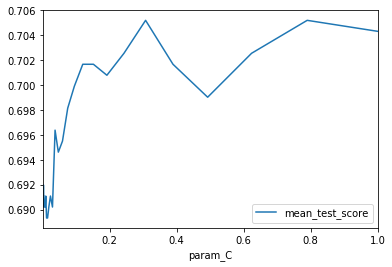

In [29]:
df_lr = pd.DataFrame(lr_gridsearch.cv_results_)
df_lr = df_lr[df_lr['param_penalty'] == 'l2']
df_lr.plot(x='param_C', y='mean_test_score')

In [30]:
lr_gridsearch.best_score_

0.705207413945278

<br>Introducing penalty does not seem to improve the model. 
<br>
<br><b>Hence, in summary, best performing model to use is the Multinomial Naive Bayes. </b>

